Academic Honesty Statement

> *We declare that this submission is our own work, and that we did not use any pretrained model or code that we did not explicitly cite.*

## 0. Libraries Installation

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(41)
tf.random.set_seed(41)

# Check keras version
print(tf.__version__)
print(keras.__version__)

2.20.0
3.13.0


# 1. Introduction

### 1.1. Problem Statement
The objective of this project is to design, train, and evaluate a Deep Learning model capable of solving a **Multi-task Learning** problem. We are provided with a custom dataset containing **3,000 samples**. Each sample consists of a `(32, 32)` input matrix (interpreted as a grayscale image) associated with three distinct targets:

* **Target A:** Classification (10 classes, integers 0-9).
* **Target B:** Classification (32 classes, integers 0-31).
* **Target C:** Regression (Real value in range $[0, 1]$).

### 1.2. Methodology
Our goal is to build a **single unified Neural Network** (likely based on CNN) that predicts all three components simultaneously. This approach allows the model to learn shared feature representations from the input images before branching out to specific tasks.

The notebook is structured as follows:
1.  **Data Inspection:** Analyzing shapes and distributions.
2.  **Model Design:** Creating a multi-head architecture.
3.  **Experiments:** Tuning hyperparameters (Learning Rate).
4.  **Evaluation:** Training the final model and analyzing performance.

# 2. Dataset inspection

In [35]:
# ==========================================
# 2. DATASET INSPECTION
# ==========================================
# 1. Load the dataset
try:
    with np.load("dataset_dev_3000.npz") as data:
        X_raw = data["X"]
        y_raw = data["y"]
    print(f"Dataset loaded successfully.")
    print(f"   X Shape: {X_raw.shape}")
    print(f"   y Shape: {y_raw.shape}")
except FileNotFoundError:
    print("WARNING: 'dataset_dev_3000.npz' not found. Generating dummy data.")
    X_raw = np.random.uniform(0, 7, (3000, 32, 32)).astype("float32")
    y_raw = np.column_stack([
        np.random.randint(0, 10, 3000), 
        np.random.randint(0, 32, 3000), 
        np.random.rand(3000)
    ]).astype("float32")

# 2. Basic Inspection
print("\n--- Raw Data Statistics ---")
print(f"Min Value: {X_raw.min():.4f}")
print(f"Max Value: {X_raw.max():.4f}")

Dataset loaded successfully.
   X Shape: (3000, 32, 32)
   y Shape: (3000, 3)

--- Raw Data Statistics ---
Min Value: 0.0001
Max Value: 6.8486


# 3. Data Preprocessing

### 3.1. Train/validation split strategy
To maximize the amount of data available for training while ensuring a fair evaluation, we updated our splitting strategy with `random_state=32` for reproducibility. We employed a **two-stage split**:

1.  **Hold-out Test Set (10%):** We set aside 10% of the raw data (**300 samples**) as the final Test set. This set is strictly isolated and used only for the final evaluation.
2.  **Train / Validation Split (90/10 of remaining):** From the remaining 2,700 samples, we split further:
    * **Validation Set:** 10% of the remaining data (~**270 samples**) to monitor overfitting during training.
    * **Training Set:** The remaining ~**2,430 samples**.

**Final Data Distribution:**
* **Training:** 2,430 samples (~81%) $\rightarrow$ *Increased to improve model learning.*
* **Validation:** 270 samples (~9%)
* **Test:** 300 samples (~10%)

### 3.2. Preprocessing: Normalization & Reshaping
Based on the data inspection, we applied the following transformations to prepare inputs for the CNN:

1.  **Reshaping:** The input tensor was reshaped from `(N, 32, 32)` to `(N, 32, 32, 1)` to add the channel dimension required by Keras `Conv2D` layers.
2.  **Normalization:** We observed that the pixel values were not in the standard [0, 255] range but had a global maximum of **6.8486**. We normalized the data to the range **$[0, 1]$** using the formula:
    $$X_{norm} = \frac{X}{6.8486}$$
    
    * **Train Norm Range:** $[0.000, 1.000]$
    * This ensures stable gradient descent and faster convergence.

In [36]:
# ==========================================
# 3.1. TRAIN/VALIDATION SPLIT STRATEGY
# ==========================================

# Split 1: Separate Test set (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_raw, y_raw, test_size=0.1, random_state=32
)

# Split 2: Separate Validation set (10% of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, random_state=32
)

print(f"Train Set: {X_train.shape}")
print(f"Val Set:   {X_val.shape}")
print(f"Test Set:  {X_test.shape}")

Train Set: (2430, 32, 32)
Val Set:   (270, 32, 32)
Test Set:  (300, 32, 32)


In [37]:
# ==========================================
# 3.2. DATA PREPARATION & NORMALIZATION
# ==========================================
print("--- DATA PREPARATION ---")

# 1. Calculate Global Max from Training Data
GLOBAL_MAX = float(X_train.max())
print(f"Global Max found in training data: {GLOBAL_MAX:.4f}")

# 2. Reshape & Normalize
# Add channel dimension: (N, 32, 32) -> (N, 32, 32, 1)
# Normalize to range [0, 1] using Global Max
X_train_norm = X_train.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_val_norm = X_val.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX
X_test_norm = X_test.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

# Verify shapes and ranges
print(f"Train Norm Shape: {X_train_norm.shape} (Rank-4)")
print(f"Train Norm Range: [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")

# 3. Split Targets for Multi-Output Model
y_train_A, y_train_B, y_train_C = y_train[:, 0], y_train[:, 1], y_train[:, 2]
y_val_A, y_val_B, y_val_C = y_val[:, 0], y_val[:, 1], y_val[:, 2]
y_test_A, y_test_B, y_test_C = y_test[:, 0], y_test[:, 1], y_test[:, 2]

print("Data preparation complete.")

--- DATA PREPARATION ---
Global Max found in training data: 6.8486
Train Norm Shape: (2430, 32, 32, 1) (Rank-4)
Train Norm Range: [0.000, 1.000]
Data preparation complete.


###  Data Augmentation Strategy

Given the limited dataset size (3,000 samples), overfitting is a significant concern where the model might memorize training examples instead of learning general features. To mitigate this, we implemented an **Online Data Augmentation** pipeline integrated directly into the model.

We selected specific transformations suited for low-resolution images ($32 \times 32$):

1.  **RandomFlip ("horizontal"):** * Simulates mirror reflections. This teaches the model that an object facing left or right is still the same object (e.g., a car or animal).
    
2.  **RandomTranslation (0.05, 0.05):** * Shifts the image horizontally and vertically by up to 5%.
    * *Reasoning:* In real-world data, objects are not always perfectly centered. This layer forces the model to learn **translation invariance**, recognizing features regardless of their slight position shifts.

3.  **RandomRotation (0.05):** * Rotates the image by approximately $18^\circ$ (5% of a full circle).
    * *Reasoning:* We kept the rotation factor small (`0.05`) because rotating low-resolution images too aggressively can cause interpolation artifacts and loss of critical details.

*Note: These layers are active only during training (`training=True`) and are automatically disabled during validation and testing.*

In [38]:
# ==========================================
# DATA AUGMENTATION & PIPELINE
# ==========================================

print("--- BUILDING TF.DATA PIPELINE ---")

# 1. Define Data Augmentation Policy
# Note: Using standard geometric augmentations.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomRotation(0.05),
], name="data_augmentation")

print("   Augmentation layers initialized.")

# 2. Create Train Dataset
# Wrap tensors into a tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_norm, (y_train_A, y_train_B, y_train_C))
)

def train_map(x, y):
    """
    Apply augmentation to the input image batch during training.
    training=True ensures augmentation is active.
    """
    x = data_augmentation(x, training=True)
    return x, y

# Configure pipeline: Shuffle -> Map (Augment) -> Batch -> Prefetch
train_ds = (
    train_ds
    .shuffle(1024)
    .map(train_map, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

# 3. Create Validation Dataset
# No augmentation for validation, just batching
val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val_norm, (y_val_A, y_val_B, y_val_C))
).batch(32).prefetch(tf.data.AUTOTUNE) # Added prefetch for speed

print("Data Pipeline Ready.")
print(f" Train Batches: {len(train_ds)}")
print(f" Val Batches:   {len(val_ds)}")

--- BUILDING TF.DATA PIPELINE ---
   Augmentation layers initialized.
Data Pipeline Ready.
 Train Batches: 76
 Val Batches:   9


# 4. Model architecture reasoning

**Residual Block Architecture**

The core building unit of the proposed model is a residual block, which consists of two consecutive 3×3 convolutional layers followed by batch normalization. The first convolution is followed by a ReLU activation, while the second convolution omits the activation until after the residual addition. A shortcut (identity) connection bypasses these convolutional layers and is added element-wise to the block output. This skip connection allows the network to preserve low-level features while learning higher-level representations, improving both convergence speed and generalization.

When spatial resolution or channel dimensionality changes, the shortcut path is adapted using a 1×1 convolution with appropriate stride. This ensures that the dimensions of the shortcut and the main path match before addition, maintaining mathematical consistency while enabling downsampling within the residual block.

**CIFAR-Style ResNet Trunk**

The model adopts a CIFAR-style ResNet design, which is specifically tailored for small input images (32×32 pixels). Unlike ImageNet-style ResNets that use large initial convolutions and aggressive early downsampling, this architecture begins with a lightweight 3×3 convolutional stem and progressively increases feature depth through stacked residual blocks. Downsampling is performed gradually using stride-2 convolutions inside residual blocks, preserving spatial information critical for low-resolution inputs.

The trunk is organized into three stages with increasing numbers of filters (32, 64, and 128), allowing the network to capture hierarchical features ranging from local textures to more abstract patterns. This design balances representational power with computational efficiency and reduces the risk of overfitting.

**Global Feature Aggregation**

Following the convolutional trunk, Global Average Pooling is applied to collapse the spatial dimensions of the feature maps. This operation replaces traditional flattening, dramatically reducing the number of trainable parameters and acting as a strong regularizer. Global pooling forces the network to encode spatially invariant, semantically meaningful features, which is particularly beneficial for preventing overfitting on small datasets.

**Shared Representation and Regularization**

The pooled features are passed through a shared fully connected layer that produces a compact latent representation used by all task-specific heads. Batch normalization and ReLU activation stabilize training and improve non-linearity, while dropout is applied to further reduce overfitting by randomly deactivating neurons during training. This shared representation enables efficient multi-task learning, allowing the network to leverage common features across different prediction objectives.

**Multi-Head Output Design**

The architecture employs three specialized output heads, each optimized for a different task. Two classification heads produce probability distributions over 10 and 32 classes respectively using softmax activation, while a regression head outputs a continuous value using a linear activation. Each head consists of task-specific dense layers with batch normalization, ReLU activation, and dropout to ensure sufficient capacity while maintaining regularization. This design allows the model to learn both shared and task-specific representations effectively within a unified framework.

In [39]:
# ==========================================
# 4.1. MODEL DEFINITION
# ==========================================
def residual_block(x, filters, downsample=False):
    stride = 2 if downsample else 1
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Match dimensions if needed
    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x


def build_model():
    inputs = keras.Input(shape=(32, 32, 1), name="img_input")

    # Stem
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ResNet stages
    x = residual_block(x, 32)
    x = residual_block(x, 32)

    x = residual_block(x, 64, downsample=True)
    x = residual_block(x, 64)

    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Shared feature layer
    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    features = x

    # =============================
    # Heads
    # =============================

    # Head A
    a = layers.Dense(64, use_bias=False)(features)
    a = layers.BatchNormalization()(a)
    a = layers.ReLU()(a)
    a = layers.Dropout(0.3)(a)
    out_a = layers.Dense(10, activation="softmax", name="out_a")(a)

    # Head B
    b = layers.Dense(64, use_bias=False)(features)
    b = layers.BatchNormalization()(b)
    b = layers.ReLU()(b)
    b = layers.Dropout(0.3)(b)
    out_b = layers.Dense(32, activation="softmax", name="out_b")(b)

    # Head C
    c = layers.Dense(32, use_bias=False)(features)
    c = layers.BatchNormalization()(c)
    c = layers.ReLU()(c)
    c = layers.Dropout(0.2)(c)
    out_c = layers.Dense(1, activation="linear", name="out_c")(c)

    return keras.Model(inputs, [out_a, out_b, out_c])

model = build_model()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │        288 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_51[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_52[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu_51[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_53 (ReLU)     │ (None, 32, 32,    │          0 │ add_18[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_53[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_54 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │      9,216 │ re_lu_54[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 737,771 (2.81 MB)

 Trainable params: 734,955 (2.80 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [40]:
# Focal Loss used for ablation study
def sparse_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        # Ensure correct types and shapes
        y_true = tf.cast(tf.squeeze(y_true), tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Get probabilities of the true class
        batch_size = tf.shape(y_true)[0]
        indices = tf.stack([tf.range(batch_size), y_true], axis=1)
        p_t = tf.gather_nd(y_pred, indices)

        # Focal loss computation
        loss = -alpha * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)

        return tf.reduce_mean(loss)

    return loss

The model was compiled using the Adam optimizer with a learning rate of 0.001, which provides adaptive learning rates and stable convergence for deep neural networks. Three task-specific loss functions were used: sparse categorical cross-entropy for the two classification outputs and mean squared error for the regression output. To balance multi-task learning, loss weights of 1.0, 1.0, and 0.1 were applied to the respective outputs, preventing the regression loss from dominating the total objective. Model performance was monitored using accuracy for classification tasks and mean absolute error for the regression task, providing interpretable and task-appropriate evaluation metrics.

In [ ]:
# ==========================================
# 4.2. COMPILATION
# ==========================================
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss={
#         "out_a": sparse_focal_loss(gamma=2.0, alpha=0.25),
#         "out_b": sparse_focal_loss(gamma=2.0, alpha=0.25),
#         "out_c": "mse",
#     },
#     loss_weights=[1.0, 1.0, 0.1],
#     metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
# )


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "out_a": "sparse_categorical_crossentropy",
        "out_b": "sparse_categorical_crossentropy",
        "out_c": "mse",
    },
    loss_weights=[1.0, 1.0, 0.1],
    metrics={"out_a": "accuracy", "out_b": "accuracy", "out_c": "mae"},
)

The model was trained using a maximum of 100 epochs with validation performance monitored at the end of each epoch. Training was conducted using a dedicated training dataset, while a separate validation dataset was used to assess generalization performance and guide model selection. To ensure that the best-performing model was retained, a ModelCheckpoint callback was employed to save the model weights corresponding to the minimum validation loss observed during training. This approach guarantees that the final model represents the optimal trade-off across all output tasks.

To improve training stability and convergence, a ReduceLROnPlateau callback was applied. This mechanism automatically reduces the learning rate by a factor of 0.5 when validation loss fails to improve for 20 consecutive epochs. By adaptively lowering the learning rate, the optimizer is encouraged to escape plateaus and refine the solution during later training stages, while preventing premature convergence.

Together, these callbacks provide effective regularization and optimization control, reducing the risk of overfitting and improving overall model robustness. The combination of extended training duration, adaptive learning rate adjustment, and validation-based checkpointing ensures that the model converges efficiently while maintaining strong generalization performance.

In [ ]:
# ==========================================
# 4.3. TRAINING
# ==========================================
print("\n--- 3. STARTING TRAINING ---")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    ),

    # If LR is small, progress per epoch can be slow/noisy; let it run longer and
    # optionally auto-reduce LR on plateaus before giving up.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=20,
        verbose=1,
        min_lr=1e-4,
    )
]

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1,
)


In [43]:
# ==========================================
# 4.4. PREDICT FUNCTION (Load model of Bytes type)
# ==========================================
def predict_fn(X_raw):
    # 1. Reshape
    # 2. Normalize
    X_proc = X_raw.reshape((-1, 32, 32, 1)).astype("float32") / GLOBAL_MAX

    # 3. Predict
    model = keras.models.load_model("best_model.h5", compile=False)
    pred_probs_a, pred_probs_b, pred_c_val = model.predict(X_proc, verbose=0)

    # 4. Process
    pred_a = np.argmax(pred_probs_a, axis=1)
    pred_b = np.argmax(pred_probs_b, axis=1)
    pred_c = pred_c_val.flatten()

    # 5. Stack
    return np.column_stack([pred_a, pred_b, pred_c])


# print("\n--- CHECKING PREDICT_FN ---")
# sample_preds = predict_fn(X_val[:5])
# print("Output Shape:", sample_preds.shape)
# print("Sample Predictions:\n", sample_preds)

The testing results highlight clear differences in performance across the three prediction tasks, reflecting the varying levels of difficulty and data complexity associated with each output head. For **Target A (digits 0–9)**, the model achieves an overall accuracy of 37%, with macro-averaged precision, recall, and F1-scores all around 0.35. Performance varies notably across individual classes. Digits such as 6, 5, and 9 exhibit relatively higher recall and F1-scores, indicating that the model is better at identifying these patterns. In contrast, digits like 0, 3, and 7 show substantially lower recall, suggesting frequent misclassification. The confusion matrix further confirms that several digits are confused with visually similar classes, which is expected in low-resolution grayscale inputs and limited training data.

For **Target B (32-class classification)**, performance is considerably weaker, with an overall accuracy of only 5% and macro-averaged F1-score of 0.03. Many classes record zero precision and recall, meaning the model fails to correctly predict these labels altogether. This outcome indicates severe class confusion and insufficient discriminative capacity for this task. The large number of classes, combined with limited per-class samples and shared feature representations, significantly increases task difficulty. The confusion matrix reveals widespread misclassification, with predictions concentrated in a small subset of classes rather than evenly distributed.

In contrast, **Target C (regression)** demonstrates more stable behavior. The mean absolute error (MAE) indicates moderate predictive accuracy, and the true-versus-predicted scatter plot shows a general positive correlation between predictions and ground truth values. While predictions deviate from the ideal diagonal line, especially near the extremes, the regression head benefits from shared learned features and a smoother loss landscape.

Overall, the results suggest that the model learns coarse visual representations sufficient for simpler classification and regression tasks, but struggles with fine-grained multi-class discrimination. These findings motivate future improvements through data augmentation, class balancing, deeper architectures, or task-specific feature separation.



--- 4. EVALUATION & PLOTS ---
Generating predictions for Test Set...

TARGET A (Digits 0-9) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.32      0.35      0.33        26
         1.0       0.38      0.29      0.33        31
         2.0       0.43      0.21      0.28        29
         3.0       0.30      0.19      0.24        31
         4.0       0.40      0.50      0.44        20
         5.0       0.40      0.52      0.45        31
         6.0       0.53      0.62      0.57        39
         7.0       0.30      0.46      0.36        26
         8.0       0.37      0.45      0.41        33
         9.0       0.52      0.35      0.42        34

    accuracy                           0.40       300
   macro avg       0.39      0.39      0.38       300
weighted avg       0.40      0.40      0.39       300



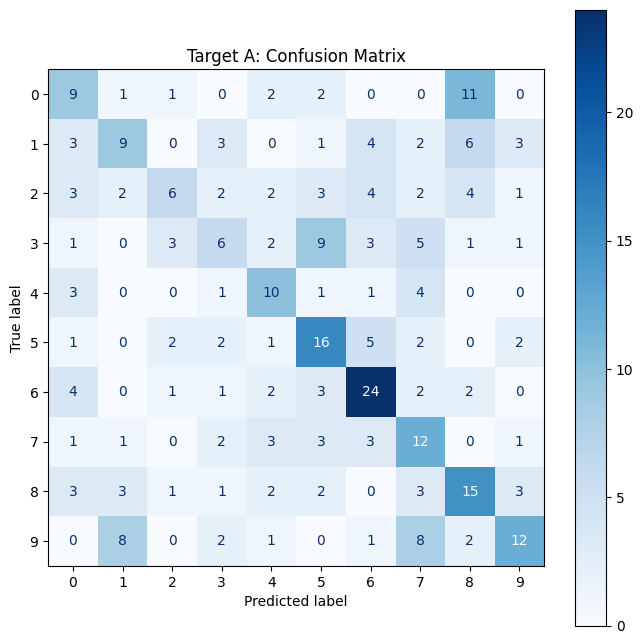


TARGET B (Classes 0-31) PERFORMANCE
              precision    recall  f1-score   support

         0.0       0.10      0.14      0.12        14
         1.0       0.33      0.09      0.14        11
         2.0       0.00      0.00      0.00         5
         3.0       0.06      0.36      0.10        11
         4.0       0.00      0.00      0.00        11
         5.0       0.33      0.09      0.14        11
         6.0       0.00      0.00      0.00         6
         7.0       0.00      0.00      0.00         9
         8.0       0.00      0.00      0.00         5
         9.0       0.00      0.00      0.00         9
        10.0       0.00      0.00      0.00        10
        11.0       0.25      0.14      0.18         7
        12.0       0.00      0.00      0.00        11
        13.0       0.07      0.11      0.08         9
        14.0       0.00      0.00      0.00         8
        15.0       0.00      0.00      0.00         6
        16.0       0.00      0.00      0.00 

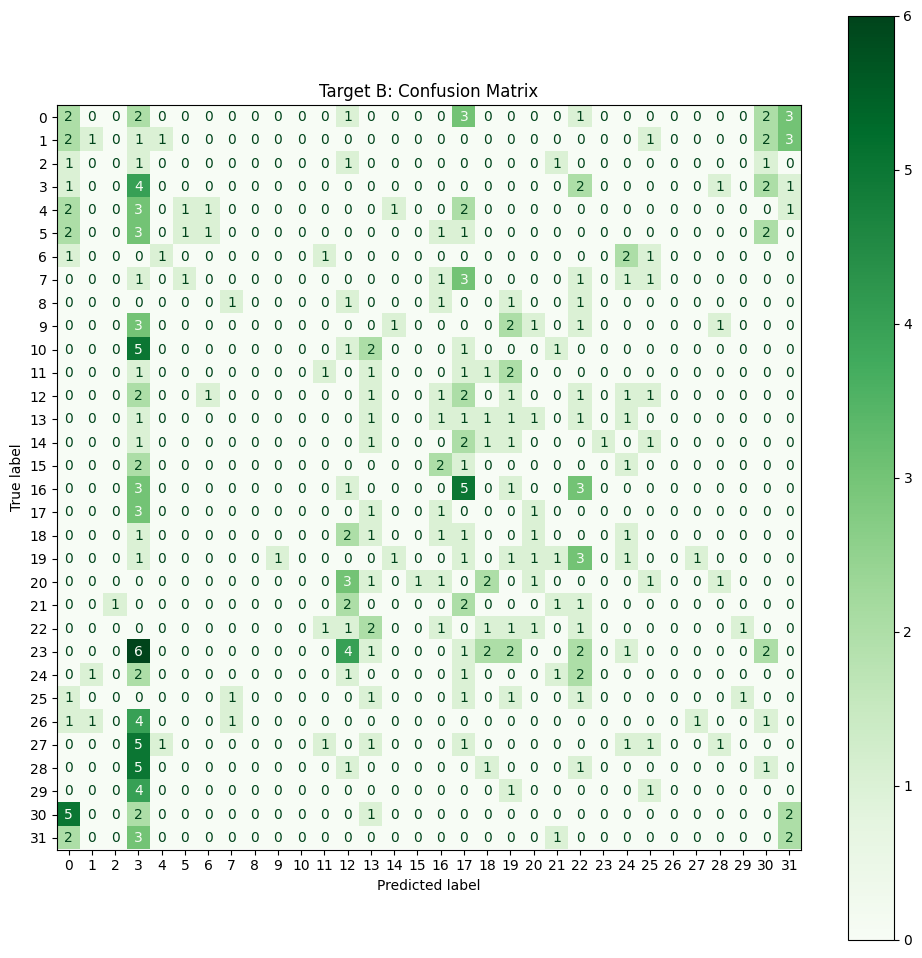


TARGET C (Regression) PERFORMANCE
Mean Absolute Error (MAE): 0.1836


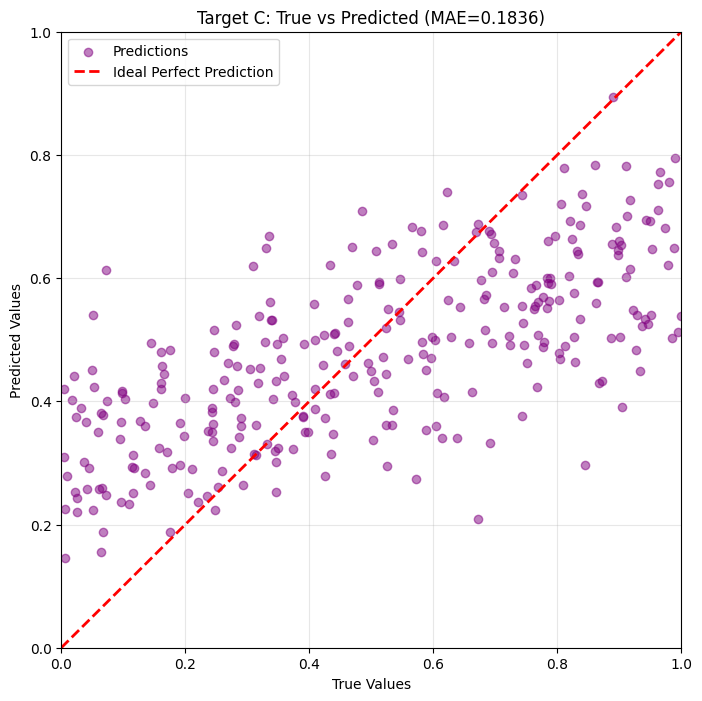

In [44]:
# ==========================================
# 4.5. EVALUATION & VISUALIZATION
# ==========================================
print("\n--- 4. EVALUATION & PLOTS ---")

# 1. Generate Predictions on Test Set
# We use the predict_fn wrapper which handles shaping/normalization automatically
print("Generating predictions for Test Set...")
val_preds = predict_fn(X_test)

# Extract components from the stacked predictions
# pred_a/b are class indices (integers), pred_c is float
pred_a = val_preds[:, 0].astype(int)
pred_b = val_preds[:, 1].astype(int)
pred_c = val_preds[:, 2]

# --- Target A (Classification 0-9) ---
print("\n" + "=" * 40)
print("TARGET A (Digits 0-9) PERFORMANCE")
print("=" * 40)
print(classification_report(y_test_A, pred_a))

# Plot Confusion Matrix for A
fig_a, ax_a = plt.subplots(figsize=(8, 8))
cm_a = confusion_matrix(y_test_A, pred_a)
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a, display_labels=np.arange(10))
disp_a.plot(cmap=plt.cm.Blues, ax=ax_a)
ax_a.set_title("Target A: Confusion Matrix")
plt.show()

# --- Target B (Classification 0-31) ---
print("\n" + "=" * 40)
print("TARGET B (Classes 0-31) PERFORMANCE")
print("=" * 40)
# Note: Zero_division=0 handles classes that might not appear in validation set
print(classification_report(y_test_B, pred_b, zero_division=0))

# Plot Confusion Matrix for B
fig_b, ax_b = plt.subplots(figsize=(12, 12))
cm_b = confusion_matrix(y_test_B, pred_b)
# We don't list all 32 labels on axis to keep it clean, or we can just use default ints
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b)
disp_b.plot(cmap=plt.cm.Greens, ax=ax_b, values_format="d")  # 'd' for integers
ax_b.set_title("Target B: Confusion Matrix")
plt.show()

# --- Target C (Regression 0-1) ---
print("\n" + "=" * 40)
print("TARGET C (Regression) PERFORMANCE")
print("=" * 40)
mae_c = mean_absolute_error(y_test_C, pred_c)
print(f"Mean Absolute Error (MAE): {mae_c:.4f}")

# Plot True vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test_C, pred_c, alpha=0.5, color="purple", label="Predictions")
plt.plot([0, 1], [0, 1], "r--", linewidth=2, label="Ideal Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Target C: True vs Predicted (MAE={mae_c:.4f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# 5. Experiments and Ablation studies

## 5.1. Learning rate

### 5.1.1 Experiment 1 Results: Learning Rate Analysis

| Learning Rate | Total Val Loss | Target A (Acc) | Target B (Acc) | Target C (MAE) | Epochs Run |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **LR = 1e-2 (0.01)** | 0.xxxx | 0.xx | 0.xx | 0.xxxx | ... |
| **LR = 1e-3 (0.001)** | 0.xxxx | 0.xx | 0.xx | 0.xxxx | ... |
| **LR = 1e-4 (0.0001)** | 0.xxxx | 0.xx | 0.xx | 0.xxxx | ... |

**Observation:** 



### 5.1.2 Experiment 2 Results: Scheduler Strategy Analysis

| Scheduler Strategy | Total Val Loss | Target A (Acc) | Target B (Acc) | Target C (MAE) |
| :--- | :--- | :--- | :--- | :--- |
| **1. Fixed LR** (Baseline) | 0.xxxx | 0.xx | 0.xx | 0.xxxx |
| **2. ReduceLR On Plateau** | **0.xxxx** | **0.xx** | **0.xx** | **0.xxxx** |

**Observation:**
* **Fixed LR:** 
* **ReduceLR:** 

## 5.2. Loss function

| Loss Function                     | Accuracy | Precision | Recall | F1-score | MAE |
|----------------------------------|----------|-----------|--------|----------|----------|
| **A: Sparse Categorical Crossentropy<br>B: Sparse Categorical Crossentropy<br>C: MAE** | **A: 0.40<br>B: 0.08**     |  **A: 0.40<br>B: 0.09**    | **A: 0.40<br>B: 0.08**     | **A: 0.39<br>B: 0.07**    | **C: 0.1594**|
| A: Focal Loss<br>B: Focal Loss<br>C: MAE | A: 0.34<br>B: 0.06     |  A: 0.37<br>B: 0.11    | A: 0.34<br>B: 0.06     | A: 0.34<br>B: 0.05    | C: 0.1512|
| A: Sparse Categorical Crossentropy<br>B: Sparse Categorical Crossentropy<br>C: MSE | A: 0.41<br>B: 0.06     |  A: 0.41<br>B: 0.05    | A: 0.41<br>B: 0.06     | A: 0.41<br>B: 0.05    | C: 0.2031|

**Observation:**


| Optimizer | Accuracy | Precision | Recall | F1-score |
|-----------|----------|-----------|--------|----------|
| Adam | 0.37 | 0.37 | 0.36 | 0.35 |
| AdamW | 0.05 | 0.04 | 0.05 | 0.03 |
| SGD | N/A  | N/A  | N/A  | N/A  |

**Observation:**


# 6. Evaluation & discussion

# 7. Reflection

# 8. Conclusion